# Investment Performance Tracker

This notebook tracks the performance of investment decisions stored in the `stock_tracker.db` / `subscribers.db` database.
It fetches historical price data using `yfinance` and calculates the Return on Investment (ROI) for various decision categories (e.g., STRONG BUY, BUY, SELL).

## Updates
- **Recovery Analysis**: Calculates how long (in days) it took for the stock to recover to its pre-drop price.
- **Outlier Removal**: Excludes data points with ROI > 100% to keep visualizations readable.

In [1]:
# Install necessary libraries if not already installed
# !pip install yfinance pandas matplotlib seaborn

In [2]:
import sqlite3
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import os

# Configuration
DB_PATH = "../subscribers.db"  # Adjust path if running from notebooks/ dir
if not os.path.exists(DB_PATH):
    # Fallback to absolute path or check current dir
    DB_PATH = "subscribers.db"
    if not os.path.exists(DB_PATH):
        # Try determining path relative to this notebook
        DB_PATH = os.path.join(os.getcwd(), "..", "subscribers.db")

print(f"Using Database: {DB_PATH}")

Using Database: ../subscribers.db


## 1. Load Data from Database

In [3]:
def load_decisions(db_path):
    conn = sqlite3.connect(db_path)
    query = """
    SELECT 
        id, symbol, price_at_decision, drop_percent, recommendation, 
        reasoning, status, timestamp, ai_score, 
        deep_research_verdict, deep_research_score
    FROM decision_points
    ORDER BY timestamp ASC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

df = load_decisions(DB_PATH)

# Preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

# Filter out test symbols
df = df[~df['symbol'].isin(['MOCK_TEST', 'TEST', 'EXAMPLE', 'XYZ'])]

# Standardize Recommendation
df['recommendation'] = df['recommendation'].str.upper().str.strip()

# Calculate Pre-Drop Price
# Price At Decision = PreDrop * (1 + drop_percent/100)
# PreDrop = Price At Decision / (1 + drop_percent/100)
df['pre_drop_price'] = df['price_at_decision'] / (1 + (df['drop_percent'] / 100))

# Display Summary
print(f"Loaded {len(df)} decisions.")
print("Columns:", df.columns.tolist())
df.head()

Loaded 1051 decisions.
Columns: ['id', 'symbol', 'price_at_decision', 'drop_percent', 'recommendation', 'reasoning', 'status', 'timestamp', 'ai_score', 'deep_research_verdict', 'deep_research_score', 'date', 'pre_drop_price']


,id,symbol,price_at_decision,drop_percent,recommendation,reasoning,status,timestamp,ai_score,deep_research_verdict,deep_research_score,date,pre_drop_price
0,176,SYM,60.48,-17.399618,0.0,*** EXECUTIVE SUMMARY ***\nI am issuing an imm...,Not Owned,2025-12-05 11:49:39,NaN,None,NaN,2025-12-05,73.22
1,177,SNOW,234.77,-11.407547,0.0,*** EXECUTIVE SUMMARY ***\nI am vetoing any lo...,Not Owned,2025-12-05 11:52:14,NaN,None,NaN,2025-12-05,265.00
2,178,TBVPF,0.34,-8.108108,0.0,*** EXECUTIVE SUMMARY ***\nThe investment comm...,Not Owned,2025-12-05 11:54:31,NaN,None,NaN,2025-12-05,0.37
3,179,LYB,43.16,-6.235064,0.0,*** EXECUTIVE SUMMARY ***\nI am issuing an imm...,Not Owned,2025-12-05 11:56:58,NaN,None,NaN,2025-12-05,46.03
4,180,MEDP,544.77,-5.502264,ANALYZING,Gemini is analyzing this stock...,Pending,2025-12-05 11:59:06,NaN,None,NaN,2025-12-05,576.49


## 2. Fetch Historical Data, Calculate ROI & Recovery

We will fetch daily close prices for each stock from the decision date to today.
We also assume "Recovery" means returning to the `Pre-Drop Price`.

In [4]:
ticker = yf.Ticker('AAPL')
# Fetch slightly before to ensure coverage, but mainly from start_date
# yfinance expects string 'YYYY-MM-DD'
#start_str = start_date.strftime('%Y-%m-%d')
hist = ticker.history(start='2026-01-13')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-01-13 00:00:00-05:00,258.720001,261.809998,258.390015,261.049988,45730800,0.0,0.0
2026-01-14 00:00:00-05:00,259.489990,261.820007,256.709991,259.959991,40019400,0.0,0.0
2026-01-15 00:00:00-05:00,260.649994,261.040009,257.049988,258.209991,39388600,0.0,0.0
2026-01-16 00:00:00-05:00,257.899994,258.899994,254.929993,255.529999,72142800,0.0,0.0
2026-01-20 00:00:00-05:00,252.729996,254.789993,243.419998,246.699997,80267500,0.0,0.0
2026-01-21 00:00:00-05:00,248.699997,251.559998,245.179993,247.649994,54641700,0.0,0.0
2026-01-22 00:00:00-05:00,249.199997,251.000000,248.149994,248.350006,39708300,0.0,0.0
2026-01-23 00:00:00-05:00,247.320007,249.410004,244.679993,248.039993,41689000,0.0,0.0
2026-01-26 00:00:00-05:00,251.479996,256.559998,249.800003,255.410004,55969200,0.0,0.0


In [5]:
def get_ticker_history(symbol, start_date):
    """
    Fetches daily history for a symbol from start_date to now.
    Returns a Series of Close prices indexed by Date.
    """
    try:
        ticker = yf.Ticker(symbol)
        # Fetch slightly before to ensure coverage, but mainly from start_date
        # yfinance expects string 'YYYY-MM-DD'
        start_str = start_date.strftime('%Y-%m-%d')
        hist = ticker.history(start=start_str)
        return hist['Close']
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")
        return pd.Series()

# Cache to avoid refetching same symbol multiple times if multiple decisions exist
price_cache = {}

def calculate_performance(row):
    symbol = row['symbol']
    start_date = row['date']
    start_price = row['price_at_decision']
    target_recovery_price = row['pre_drop_price']
    
    # Unique Key for cache: Symbol + StartDate
    if symbol not in price_cache:
        price_cache[symbol] = get_ticker_history(symbol, start_date)
    
    hist = price_cache[symbol]
    
    if hist.empty:
        return None
        
    hist = hist[hist.index.date >= start_date]
    
    if hist.empty:
        return None

    latest_price = hist.iloc[-1]
    roi = ((latest_price - start_price) / start_price) * 100
    
    # Calculate Days to Recover
    days_to_recover = np.nan
    recovered = False
    
    # Find first day where price >= target_recovery_price
    # Note: price_at_decision might be lower than pre_drop_price if drop_percent is negative.
    # If drop_percent was positive (price went up?), logic holds inverse.
    # Assuming drop_percent is e.g. -10.0
    
    check_recovery = hist[hist >= target_recovery_price]
    if not check_recovery.empty:
        recovery_date = check_recovery.index[0].date()
        days_to_recover = (recovery_date - start_date).days
        recovered = True
    
    return {
        'current_price': latest_price,
        'roi_percent': roi,
        'days_held': (datetime.now().date() - start_date).days,
        'days_to_recover': days_to_recover,
        'recovered': recovered
    }

print("Fetching price data... (This may take a moment)")

# Iterate and Calculate
for index, row in df.iterrows():
    perf = calculate_performance(row)
    if perf:
        df.at[index, 'current_price'] = perf['current_price']
        df.at[index, 'roi_percent'] = perf['roi_percent']
        df.at[index, 'days_held'] = perf['days_held']
        df.at[index, 'days_to_recover'] = perf['days_to_recover']
        df.at[index, 'recovered'] = perf['recovered']
    else:
        df.at[index, 'current_price'] = np.nan
        df.at[index, 'roi_percent'] = np.nan

print("Done.")
# Drop rows where data couldn't be fetched
df_clean = df.dropna(subset=['roi_percent']).copy()

Fetching price data... (This may take a moment)


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 002402"}}}
$002402: possibly delisted; no timezone found
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 4704"}}}
$4704: possibly delisted; no timezone found
$0TCP: possibly delisted; no timezone found
$A40PU6: possibly delisted; no timezone found
$0RPY: possibly delisted; no timezone found
$SREN: possibly delisted; no price data found  (1d 2025-12-05 -> 2026-01-29)
$300979: possibly delisted; no timezone found
$0QL6: possibly delisted; no timezone found
$688775: possibly delisted; no timezone found
$BOOZT: possibly delisted; no timezone found
$601872: possibly delisted; no timezone found
$A2PMY9: possibly delisted; no timezone found
$1B2: possibly delisted; no timezone found
$A3EH8Z: possibly delisted; no timezone found
$MOTV3F: possibly delisted; no timezone found
$BOOZT_DKK: possibly delisted; no t

Done.


## 3. Filtering & Outlier Removal

1. Filter Data by Deep Research Verdict: `None`, `WAIT_FOR_STABILIZATION`, `SPECULATIVE_BUY`, `HARD_AVOID`, `STRONG_BUY`
2. Remove Outliers: Exclude entries with ROI greater than 100%.

In [6]:
df_clean.shape

(546, 18)

In [7]:
df_clean.days_to_recover

0       38.0
1        NaN
2        4.0
3       32.0
4       31.0
        ... 
1034     NaN
1035     NaN
1036     NaN
1037     NaN
1042     0.0
Name: days_to_recover, Length: 546, dtype: float64

In [8]:
# 1. Deep Research Filter
valid_verdicts = [None, 'WAIT_FOR_STABILIZATION', 'SPECULATIVE_BUY', 'HARD_AVOID', 'STRONG_BUY']
mask_verdict = df_clean['deep_research_verdict'].isin(valid_verdicts) | df_clean['deep_research_verdict'].isna()
df_clean = df_clean[mask_verdict].copy()

# 2. Outlier Removal (ROI > 100%)
original_count = len(df_clean)
df_clean = df_clean[df_clean['roi_percent'] <= 100]
pruned_count = original_count - len(df_clean)

print(f"Filtered Data Count: {len(df_clean)} (Pruned {pruned_count} outliers > 100% ROI)")

Filtered Data Count: 529 (Pruned 12 outliers > 100% ROI)


## 4. Recovery Analysis

How long does it take for stocks to recover to their pre-drop price?

In [9]:
df_clean_recommended = df_clean[df_clean.recommendation.isin(['HOLD', 'SPECULATIVE BUY','BUY', 'SELL', 'STRONG SELL', 'STRONG BUY'])]

In [10]:
pd.crosstab(df_clean_recommended['deep_research_verdict'], df_clean_recommended['recovered'])

recovered,False,True
deep_research_verdict,,
HARD_AVOID,5,1
SPECULATIVE_BUY,13,21
STRONG_BUY,3,0
WAIT_FOR_STABILIZATION,50,48


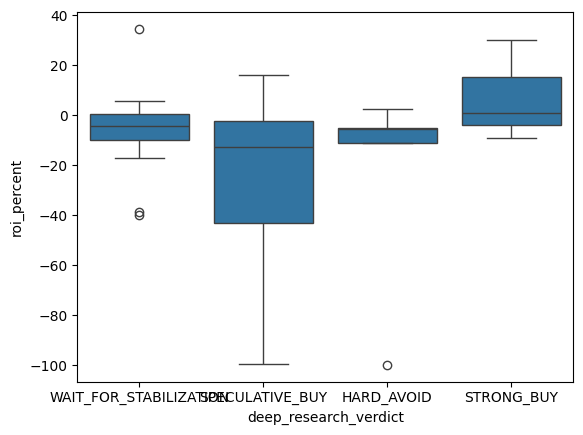

In [11]:
# Filter for items that have actually recovered
df_not_recovered = df_clean_recommended[df_clean_recommended['recovered'] == 0]


sns.boxplot(x='deep_research_verdict', y='roi_percent', data=df_not_recovered)
plt.show()


Stocks Recovered: 223 / 529 (42.2%)
Average Days to Recover: 16.3
Median Days to Recover: 12.0


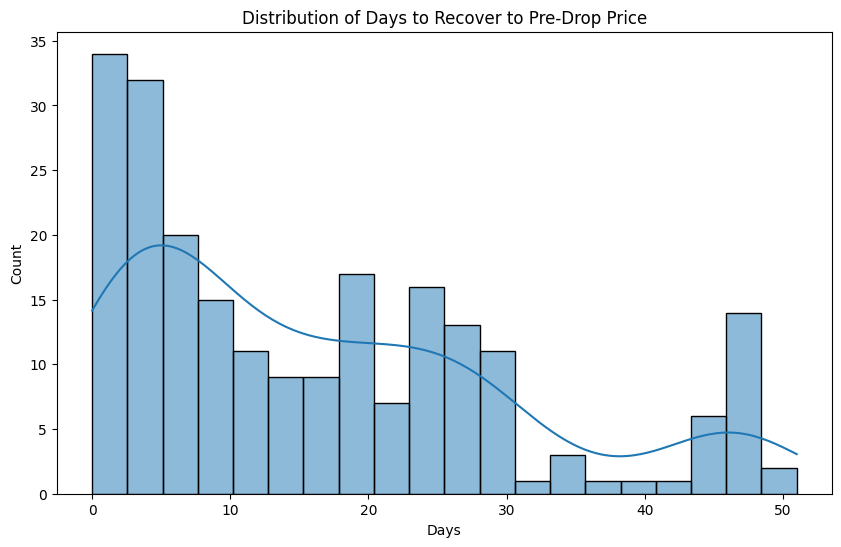

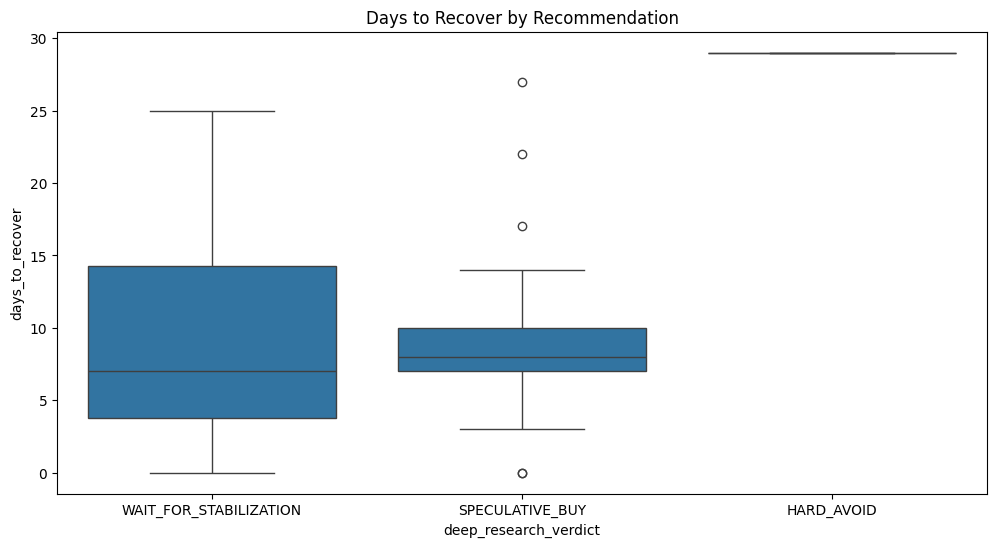

In [12]:
# Filter for items that have actually recovered
df_recovered = df_clean_recommended[df_clean_recommended['recovered'] == 1]

if not df_recovered.empty:
    print(f"Stocks Recovered: {len(df_recovered)} / {len(df_clean)} ({len(df_recovered)/len(df_clean)*100:.1f}%)")
    
    avg_days = df_recovered['days_to_recover'].mean()
    median_days = df_recovered['days_to_recover'].median()
    print(f"Average Days to Recover: {avg_days:.1f}")
    print(f"Median Days to Recover: {median_days:.1f}")

    # Histogram of Recovery Days
    plt.figure(figsize=(10, 6))
    sns.histplot(df_recovered['days_to_recover'], bins=20, kde=True)
    plt.title('Distribution of Days to Recover to Pre-Drop Price')
    plt.xlabel('Days')
    plt.ylabel('Count')
    plt.show()
    
    # Recover Days by Recommendation
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='deep_research_verdict', y='days_to_recover', data=df_recovered)
    plt.title('Days to Recover by Recommendation')
    plt.show()
else:
    print("No stocks in this filtered set have recovered yet.")

## 5. Performance by Recommendation (Cleaned)


                        count       mean    median        min        max
deep_research_verdict                                                   
HARD_AVOID                  6 -16.511815 -5.342994 -99.842007  19.647354
SPECULATIVE_BUY            34   3.702106  8.235984 -99.357143  67.818295
STRONG_BUY                  3   7.340674  0.791209  -8.878779  30.109591
WAIT_FOR_STABILIZATION     98   3.123819  0.555414 -40.047533  65.242404


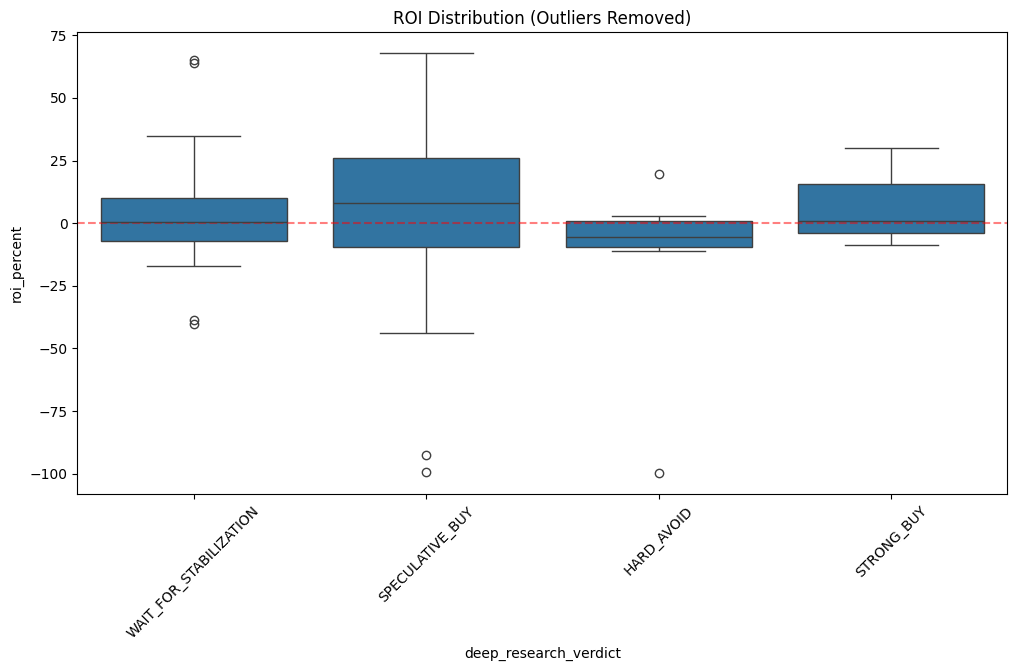

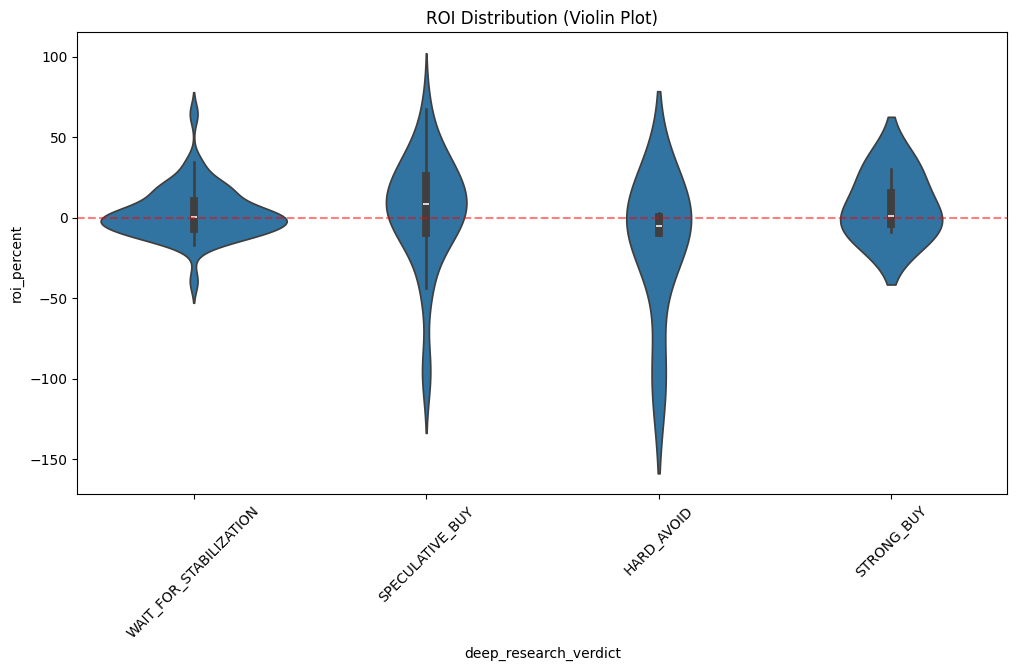

In [13]:
summary = df_clean_recommended.groupby('deep_research_verdict')['roi_percent'].agg(['count', 'mean', 'median', 'min', 'max'])
print(summary)

plt.figure(figsize=(12, 6))
sns.boxplot(x='deep_research_verdict', y='roi_percent', data=df_clean_recommended)
plt.title('ROI Distribution (Outliers Removed)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x='deep_research_verdict', y='roi_percent', data=df_clean_recommended)
plt.title('ROI Distribution (Violin Plot)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

## 6. Scoring vs Performance

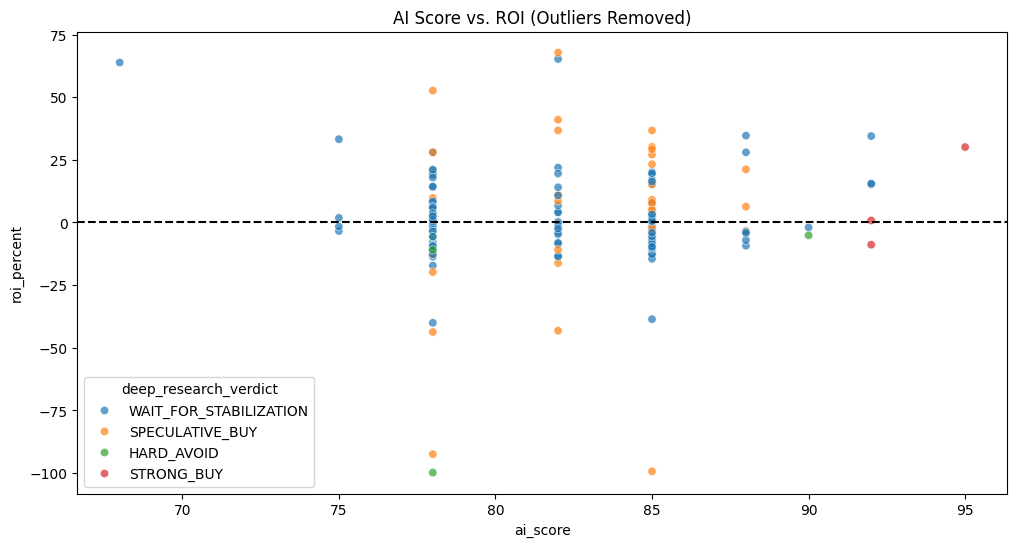

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ai_score', y='roi_percent', hue='deep_research_verdict', data=df_clean_recommended, alpha=0.7)
plt.title('AI Score vs. ROI (Outliers Removed)')
plt.axhline(0, color='black', linestyle='--')
plt.show()

## 7. Performance Over Time

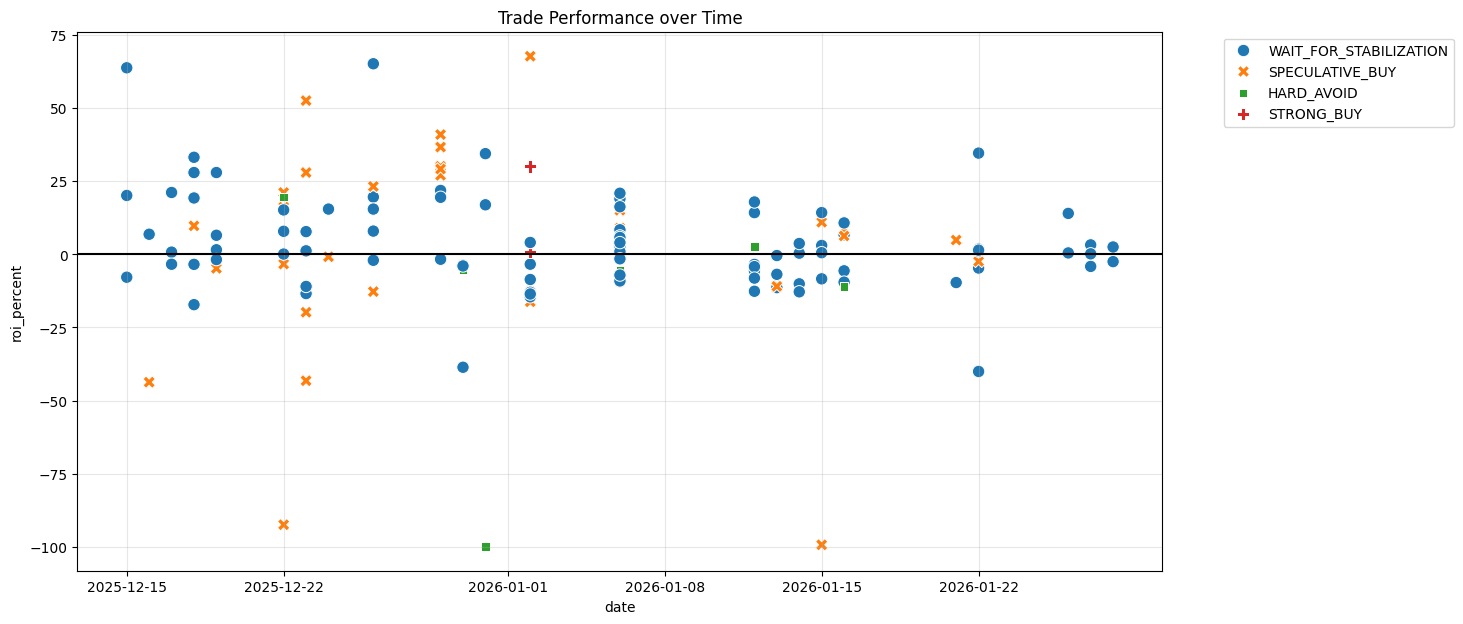

In [15]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='date', y='roi_percent', hue='deep_research_verdict', data=df_clean_recommended, style='deep_research_verdict', s=80)
plt.title('Trade Performance over Time')
plt.axhline(0, color='black', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
df_clean_recommended.groupby('deep_research_verdict').roi_percent.agg(['count', 'mean', 'median', 'min', 'max'])

,count,mean,median,min,max
deep_research_verdict,,,,,
HARD_AVOID,6,-16.511815,-5.342994,-99.842007,19.647354
SPECULATIVE_BUY,34,3.702106,8.235984,-99.357143,67.818295
STRONG_BUY,3,7.340674,0.791209,-8.878779,30.109591
WAIT_FOR_STABILIZATION,98,3.123819,0.555414,-40.047533,65.242404


## 7. 1-Month Performance Analysis

Analysis of stock performance exactly one month after the recommendation.

Fetching/Updating price data for 1-month analysis...


/var/folders/rv/mynhr5bs39d1wlydjj5t8b0c0000gn/T/ipykernel_36871/924452922.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_1m = yf.download(symbols, period="1y", group_by='ticker', progress=False, threads=True)
Failed to get ticker 'AXIA/P' reason: Expecting value: line 1 column 1 (char 0)

348 Failed downloads:
['A0MNX4', 'A2NB49', 'ITSA3', 'A2QQ2E', 'A2PPXB', '247540', '0YXG', '0GRX', '3443', 'A0CBDJ', 'AIXA', 'NA9', '3UX', 'EMBLA', '4506', '0R0A', 'THULE', 'BBDC3F', 'SFT', 'A2QLNR', '601872', '015760', 'A0DNH7', '603019', 'TIH1', '000426', '373220', 'AXIA3', 'A3C7R6', '300207', '0GWL', 'A3CV9D', 'C2OI34', '002294', '3U2', '5CV', '5838', '0QS9', '0H9X', '010950', '601933', 'A3DWD8', '051915', 'A1W2YK', 'S92', 'A3EH8Z', '010130', '0QGH', '882667', '0IIM', '0N5I', '0JK4', '0A37', '600988', '600795', 'A2PMY9', 'MILDEF', '688313', '877528', 'A0RNL2', '0QWN', 'E3B', 'A2QQBE', 'A0HGPT', 'BBAS3F', '0DHC', '0IYQ', '0NP9', '862191', '0ABY', '096770'

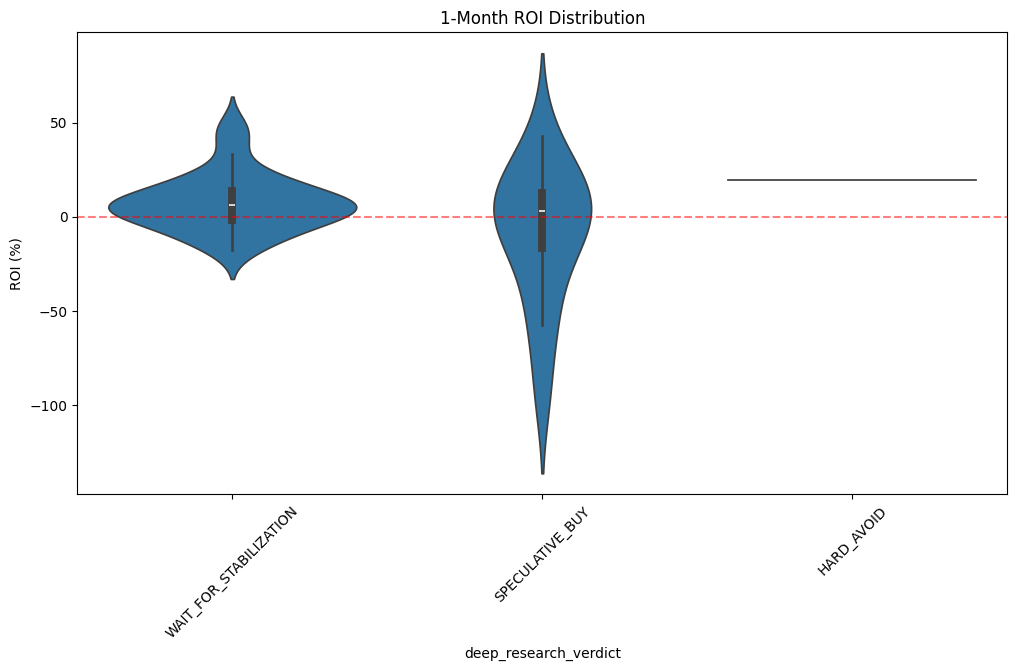

In [17]:
# Calculate 1-Month ROI
from datetime import timedelta
import yfinance as yf

# Ensure we have the data
# We might need to re-fetch if previous fetch was limited or 1w specific
# For safety, let's fetch SP500 and ensure we have stock data for the required window

print("Fetching/Updating price data for 1-month analysis...")
symbols = df['symbol'].unique().tolist()
if '^GSPC' not in symbols:
    symbols.append('^GSPC')

# Fetch 1y data to be safe
try:
    data_1m = yf.download(symbols, period="1y", group_by='ticker', progress=False, threads=True)
except Exception as e:
    print(f"Error downloading data: {e}")
    data_1m = pd.DataFrame()

rois_1m = []
timestamps_valid = []

for idx, row in df.iterrows():
    sym = row['symbol']
    start_date = row['timestamp']
    target_date = start_date + timedelta(days=30)
    
    roi = None
    try:
        if len(symbols) > 1:
            if sym in data_1m.columns.levels[0]:
                hist = data_1m[sym]['Close']
            else:
                rois_1m.append(None)
                continue
        else:
            hist = data_1m['Close']
            
        # TZ handling
        if hist.index.tz is not None:
            hist.index = hist.index.tz_localize(None)
            
        # START Price (use price_at_decision or fetch actual?)
        # Using price_at_decision is safer for consistency with recommendation
        start_price = row['price_at_decision']
        
        # TARGET Price
        future = hist[hist.index >= target_date]
        if not future.empty:
            end_price = future.iloc[0]
            roi = (end_price - start_price) / start_price * 100
            
    except Exception as e:
        pass
        
    rois_1m.append(roi)

df['roi_1m'] = rois_1m

# Filter for Plotting
df_plot_1m = df.dropna(subset=['roi_1m'])
df_plot_1m = df_plot_1m[df_plot_1m['roi_1m'].between(-100, 200)] # Basic outlier removal
valid_verdicts = ['HARD_AVOID', 'SPECULATIVE_BUY', 'STRONG_BUY', 'WAIT_FOR_STABILIZATION']
df_plot_1m = df_plot_1m[df_plot_1m['deep_research_verdict'].isin(valid_verdicts)]

plt.figure(figsize=(12, 6))
sns.violinplot(x='deep_research_verdict', y='roi_1m', data=df_plot_1m)
plt.title('1-Month ROI Distribution')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('ROI (%)')
plt.show()

## 8. S&P 500 Normalized Performance

Performance relative to the S&P 500 (Alpha) over the same 1-month period.

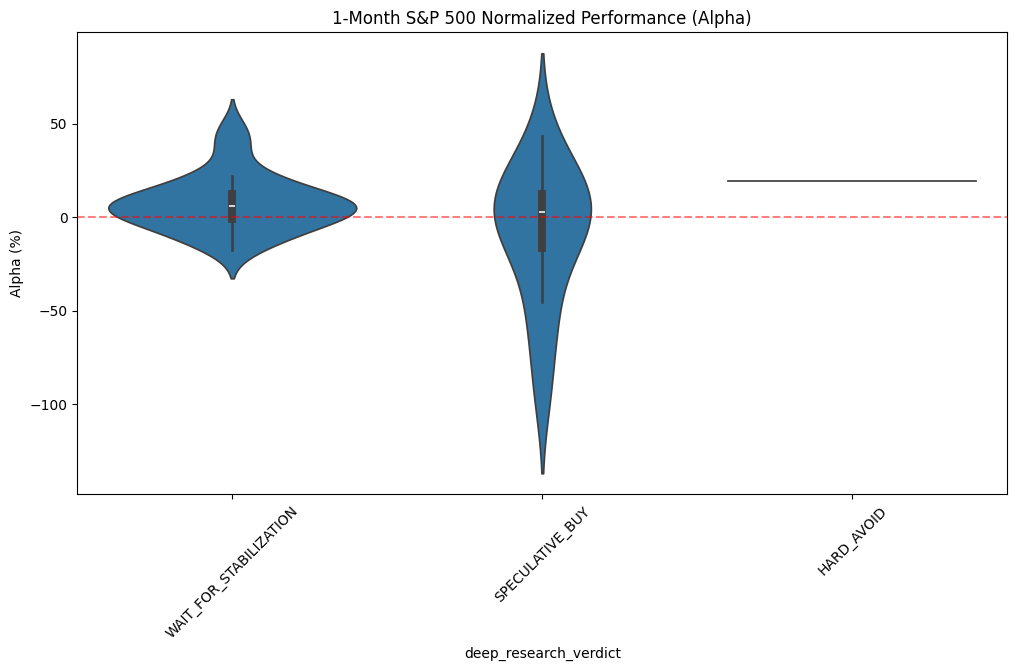

In [18]:
# Calculate Normalized ROI (Alpha)
rois_norm = []

sp500_hist = None
try:
    if '^GSPC' in data_1m.columns.levels[0]:
        sp500_hist = data_1m['^GSPC']['Close']
        if sp500_hist.index.tz is not None:
            sp500_hist.index = sp500_hist.index.tz_localize(None)
except:
    print("S&P 500 data not found in batch.")

if sp500_hist is not None:
    for idx, row in df.iterrows():
        # Only calculate if we verified stock ROI exists
        stock_roi = row['roi_1m']
        if pd.isna(stock_roi):
            rois_norm.append(None)
            continue
            
        start_date = row['timestamp']
        target_date = start_date + timedelta(days=30)
        
        try:
            # SP500 Start
            sp_start_slice = sp500_hist[sp500_hist.index >= start_date]
            if sp_start_slice.empty:
                rois_norm.append(None)
                continue
            sp_start_val = sp_start_slice.iloc[0]
            
            # SP500 End
            sp_end_slice = sp500_hist[sp500_hist.index >= target_date]
            if sp_end_slice.empty:
                rois_norm.append(None)
                continue
            sp_end_val = sp_end_slice.iloc[0]
            
            sp_roi = (sp_end_val - sp_start_val) / sp_start_val * 100
            
            # Alpha = Stock ROI - Benchmark ROI
            alpha = stock_roi - sp_roi
            rois_norm.append(alpha)
            
        except Exception as e:
            rois_norm.append(None)
else:
    print("Cannot calculate normalized ROI without S&P 500 data.")
    rois_norm = [None] * len(df)

df['roi_1m_norm'] = rois_norm

# Filter for Plotting
df_plot_norm = df.dropna(subset=['roi_1m_norm'])
df_plot_norm = df_plot_norm[df_plot_norm['roi_1m_norm'].between(-100, 200)]
df_plot_norm = df_plot_norm[df_plot_norm['deep_research_verdict'].isin(valid_verdicts)]

plt.figure(figsize=(12, 6))
sns.violinplot(x='deep_research_verdict', y='roi_1m_norm', data=df_plot_norm)
plt.title('1-Month S&P 500 Normalized Performance (Alpha)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Alpha (%)')
plt.show()